In [1]:
import pandas as pd
train = pd.read_csv('./news+aggregator/train.txt', sep="\t", header=0,names=["TITLE","CATEGORY"])
test = pd.read_csv('./news+aggregator/test.txt', sep="\t", header=0,names=["TITLE","CATEGORY"])
valid = pd.read_csv('./news+aggregator/valid.txt', sep="\t", header=0,names=["TITLE","CATEGORY"])
train_X = pd.read_csv('train.feature.txt', sep="\t")
test_X = pd.read_csv('test.feature.txt', sep="\t")
valid_X = pd.read_csv('valid.feature.txt', sep="\t")

from sklearn.linear_model import LogisticRegression
# モデルの学習
lg = LogisticRegression(random_state=64, max_iter=10000)
lg.fit(train_X, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=64)

In [2]:
import numpy as np

def score(lg, X):
    pred = lg.predict(X)                               #テストケースの分類
    proba = np.max(lg.predict_proba(X), axis=1)        #各ラベルに対する確率のうち最大値を求める
    return pred, proba

train_pred, train_proba = score(lg, train_X)
test_pred, test_proba = score(lg, test_X)
valid_pred, valid_proba = score(lg, valid_X)

print(train_pred)
print(train_proba)

['e' 'b' 'e' ... 'b' 'b' 'b']
[0.86724497 0.44265696 0.77654145 ... 0.94734514 0.58462121 0.82572831]


In [3]:
from sklearn.metrics import accuracy_score

#分類の精度を計算
train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)

#表示
print('正解率（学習データ）：{}'.format(train_accuracy))
print('正解率（評価データ）：{}'.format(valid_accuracy))
print('正解率（テストデータ）：{}'.format(test_accuracy))

正解率（学習データ）：0.931784107946027
正解率（評価データ）：0.8883058470764618
正解率（テストデータ）：0.9017991004497751


In [6]:
#単語を配列化
feature_names = train_X.columns.values

#ラベルについてのループ
for i in range(len(lg.classes_)):
    coef = lg.coef_[i]                                                                        #係数を抽出
    features = [(feature_names[j], np.abs(coef[j])) for j in range(len(feature_names))]       #単語と係数の絶対値をタプルで保存
    print('カテゴリ: {} ================'.format(lg.classes_[i]))
    bests = sorted(features, key=lambda w: w[1], reverse=True)                                #featuresを昇順に
    worsts = sorted(features, key=lambda w: w[1])                                             #featuresを降順に
    print('重みの高いtop10')
    for k in range(10):
        print('{}\t{}\t{}'.format(k + 1, bests[k][0], bests[k][1]))
    print('重みの低いtop10')
    for k in range(10):
        print('{}\t{}\t{}'.format(k + 1, worsts[k][0], worsts[k][1]))

カテゴリ: b ================
重みの高いtop10
1	bank	3.6660065662121806
2	fed	3.296427623735578
3	china	3.14807023370828
4	ecb	2.995413051576361
5	ukrain	2.5873823261262934
6	profit	2.504217354412138
7	updat	2.4792760602952364
8	euro	2.4467248509571164
9	oil	2.386662348730218
10	stock	2.344358692014293
重みの低いtop10
1	with new	0.00039451166367446576
2	mysteri	0.0005802742672741032
3	boost	0.0006770610911063066
4	everyon	0.000688410819907838
5	eli	0.0007055866843058232
6	fill	0.0007702292589575576
7	progress	0.000799923320322686
8	disrupt	0.0009681470347899594
9	down in	0.0010216993890357555
10	prevent	0.001115654496476337
カテゴリ: e ================
重みの高いtop10
1	updat	3.2263012318511284
2	googl	2.7567134451316253
3	kardashian	2.750934870706636
4	us	2.648413516437356
5	film	2.5966166316868824
6	chri	2.5710474945987443
7	movi	2.4936079095054353
8	wed	2.2602503414442703
9	studi	2.2360314377121053
10	china	2.2308487922961246
重みの低いtop10
1	yr	1.1341011227226822e-05
2	away	0.0004384644306200309
3	hard	0.0008

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
results = []                                                         #結果を保存する配列
#tqdmによって進捗を表示
for c in tqdm(np.logspace(-4, 2, 10, base=10)):                      #10^(-4)~10^2までの範囲でループ

    # モデルの学習
    lg = LogisticRegression(random_state=64, max_iter=10000, C=c)    #Cは正則化の強さを指定
    lg.fit(train_X, train['CATEGORY'])
    
    # 予測
    train_pred = lg.predict(train_X)
    valid_pred = lg.predict(valid_X)
    test_pred = lg.predict(test_X)
    
    # 評価
    train_acc = accuracy_score(train['CATEGORY'], train_pred)
    valid_acc = accuracy_score(valid['CATEGORY'], valid_pred)
    test_acc = accuracy_score(test['CATEGORY'], test_pred)
    results.append([c, train_acc, valid_acc, test_acc])               #結果をresultに追加

results = np.array(results)

100%|██████████| 10/10 [02:56<00:00, 17.69s/it]


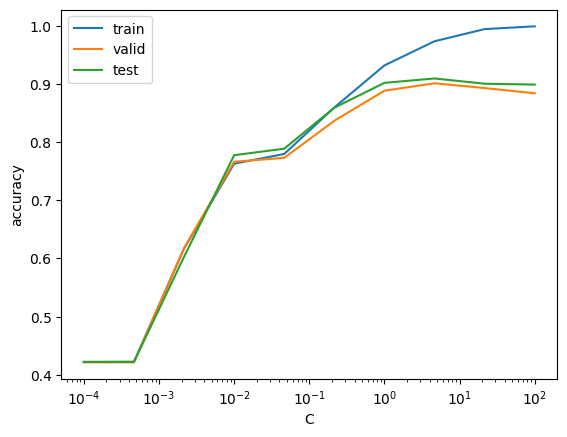

In [5]:
#グラフの作成
fig, ax = plt.subplots()                                              #図と軸のインスタンスを作成
ax.plot(results[:, 0], results[:, 1], label='train')                  #スライスによって、横軸と縦軸のデータを抽出
ax.plot(results[:, 0], results[:, 2], label='valid')
ax.plot(results[:, 0], results[:, 3], label='test')
ax.set_xlabel('C')                                                    #ラベルの作成
ax.set_ylabel('accuracy')
ax.set_xscale('log')                                                  #横軸のスケーリング
plt.legend()
plt.show()